In [1]:

import zarr
import pickle
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from rich import print
from pathlib import Path
from omegaconf import OmegaConf
from dataclasses import dataclass, fields
from alive_progress import alive_it
from sortedcontainers import SortedList
from walrus_workshop.utils import get_key_value_from_string
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.model import load_sae
from walrus_workshop.metrics import compute_enstrophy, compute_deformation

from script_linear_probe_regression import ProbeResult, get_data_chunk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [2]:
# Load the config
cfg = OmegaConf.load("configs/train.yaml")

# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()

In [3]:
# Load the trajectory
trajectory_id = 50
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

In [5]:
target = 'deformation'
# with open(f'probes/prob_results_traj_{trajectory_id}_{target}.pkl', 'rb') as f:
with open(r"/home/krosenfeld/projects/walrus-workshop/experiments/well/probes/probe_results_traj_50_deformation.pkl", "rb") as f:
    prob_results = pickle.load(f)
# probl results are sorted in order of r_squared
fields(prob_results[0])


(Field(name='feature_idx',type=<class 'int'>,default=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='r_squared',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='spearman_rho',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,default_factory=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='spearman_p',type=<class 'float'>,default=<dataclasses._MISSING_TYPE object at 0x7fd48295d400>,default_factory=<dataclasses._MISSING_TYPE object at 

In [9]:
np.argmax([result.r_squared for result in prob_results])
print(prob_results[0].r_squared_conditional)

0.16065443

Step 1

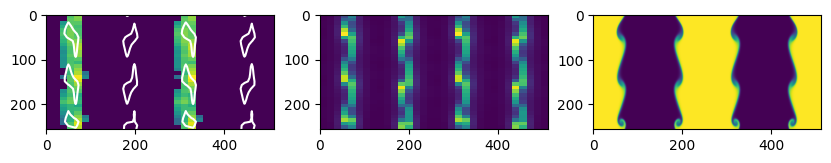

Found 1 steps with non-zero activation (2.94%)

In [10]:
def make_plot(data_chunk, result):
    extent = (-0.5, 512.5, 256.5, -0.5)
    print(f"Step {data_chunk.step}")
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    ax = axs[0]
    ax.imshow(data_chunk.code[..., result.feature_idx], extent=extent)
    ax.contour(np.linspace(0, 512, 32), np.linspace(0, 256, 32), data_chunk.target, levels=1, colors='w')
    # ax.contour(np.arange(data_chunk.simulation.shape[1]), np.arange(data_chunk.simulation.shape[0]), data_chunk.simulation[..., 0], levels=1)
    ax = axs[1]
    ax.imshow(data_chunk.target, extent=extent)
    ax = axs[2]
    ax.imshow(data_chunk.simulation[..., 0])
    plt.show()

result = prob_results[0]
cnt = 0
for step_index in range(len(steps)):
    data_chunk = get_data_chunk(step=steps[step_index], step_index=step_index, act_files=act_files, trajectory=trajectory, cfg=cfg, sae_model=sae_model, device=device, verbose=False, target=target)
    if np.any(data_chunk.code[..., result.feature_idx] > 0):
        cnt += 1
        make_plot(data_chunk, result)
print(f"Found {cnt} steps with non-zero activation ({cnt / len(steps) * 100:.2f}%)")

Step 2

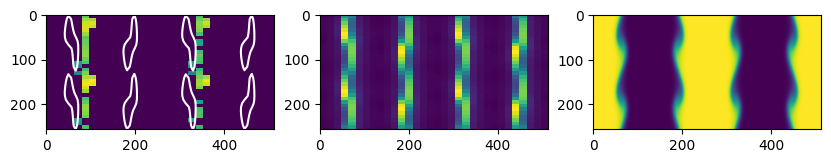

Found 1 steps with non-zero activation (2.94%)

In [11]:
# Load the trajectory
trajectory_id = 56
trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, trajectory_id)

# Load file list of the activations
activations_dir = (
    Path("activations")
    / "test"
    / "blocks.20.space_mixing.activation"
    / cfg.walrus.dataset
)
act_files = sorted(glob.glob(str(activations_dir / f"*_traj_{trajectory_id}*")))
# List of steps with activations (starting step)
steps = np.array([int(get_key_value_from_string(file_name, "step")) for file_name in act_files])

cnt = 0
for step_index in range(len(steps)):
    data_chunk = get_data_chunk(step=steps[step_index], step_index=step_index, act_files=act_files, trajectory=trajectory, cfg=cfg, sae_model=sae_model, device=device, verbose=False, target=target)
    if np.any(data_chunk.code[..., result.feature_idx] > 0):
        cnt += 1
        make_plot(data_chunk, result)
print(f"Found {cnt} steps with non-zero activation ({cnt / len(steps) * 100:.2f}%)")


In [ ]:
[]